In [ ]:
# 해당 코드는 colab에서 작성되었음음
!pip install -qU datasets torchinfo openai

In [ ]:
# 해당 코드는 colab에서 작성되었음음
!huggingface-cli login

# DistilBert Finetuning by Huggingface Trainer
- 1. Task:

    1) nyu-mll/glue의 mnli 데이터셋에 대한 distill bert의 분류 성능을 측정해야 합니다.

- 2. 더 해볼 과제:

    1) 언어 모델 앙상블과 chain of thought prompt engineering을 통해 텍스트를 분류해볼 것입니다.

    2) openai api 또한 간단히 사용할 예정입니다.

    3) Distill bert로 분류한 것과 간단히 성능을 비교해보겠습니다.



##1 [My Code] Preparation


###1.1 [My Code] Model Config

In [ ]:
import torch
# 모델 config입니다.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_name = "distilbert-base-uncased"
ds_name = "nyu-mll/glue"
ds_config = "mnli"

n_labels = 3

test_size1 = 0.1
test_size2 = 0.2222
random_state = 42
batch_size = 64
max_len = 400

results_dir = './results/week4_basic'
lr = 2e-5
n_epochs = 10

### 1.2 [My Code] Load Model Tokenizer

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from datasets import load_dataset
import pandas as pd

# Parquet 형태의 데이터셋입니다.
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=n_labels)
model = model.to(device)
raw_dataset = load_dataset(ds_name, ds_config)
label2idx = {'entailment':0,'neutral':1,'contradiction':2}

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 1.3 [My Code] Model Info

In [ ]:
import torch
from torchinfo import summary
# 모델 정보 출력
vocab_size = len(tokenizer)
# vocab 안에서의 인덱스까지의 데이터
dummy_input_ids = torch.randint(0, vocab_size, (batch_size, max_len))
dummy_attention_mask = torch.ones(batch_size, max_len, dtype=torch.int64)

# 모델 요약 출력
print("Model Summary")
print("Vocab_size ", vocab_size)
print("Input Shape ", dummy_input_ids.shape)
print("Attention_Mask Shape ", dummy_attention_mask.shape)
print(summary(model, input_data={"input_ids": dummy_input_ids.to(device), "attention_mask": dummy_attention_mask.to(device)}))

Model Summary
Vocab_size  30522
Input Shape  torch.Size([64, 400])
Attention_Mask Shape  torch.Size([64, 400])
Layer (type:depth-idx)                                  Output Shape              Param #
DistilBertForSequenceClassification                     [64, 3]                   --
├─DistilBertModel: 1-1                                  [64, 400, 768]            --
│    └─Embeddings: 2-1                                  [64, 400, 768]            --
│    │    └─Embedding: 3-1                              [64, 400, 768]            23,440,896
│    │    └─Embedding: 3-2                              [1, 400, 768]             393,216
│    │    └─LayerNorm: 3-3                              [64, 400, 768]            1,536
│    │    └─Dropout: 3-4                                [64, 400, 768]            --
│    └─Transformer: 2-2                                 [64, 400, 768]            --
│    │    └─ModuleList: 3-5                             --                        42,527,232
├─Linear: 

In [ ]:
# classifier만 학습시킬 것이기에 distilbert layer까지의 파라미터는 동결되어야 합니다.
# torchunfo에서 파라미터수가 제한된 것을 알 수 있습니다.
for param in model.distilbert.parameters():
    param.requires_grad = False

print("Model Summary")
print("Vocab_size ", vocab_size)
print("Input Shape ", dummy_input_ids.shape)
print("Attention_Mask Shape ", dummy_attention_mask.shape)
print(summary(model, input_data={"input_ids": dummy_input_ids.to(device), "attention_mask": dummy_attention_mask.to(device)}))

Model Summary
Vocab_size  30522
Input Shape  torch.Size([64, 400])
Attention_Mask Shape  torch.Size([64, 400])
Layer (type:depth-idx)                                  Output Shape              Param #
DistilBertForSequenceClassification                     [64, 3]                   --
├─DistilBertModel: 1-1                                  [64, 400, 768]            --
│    └─Embeddings: 2-1                                  [64, 400, 768]            --
│    │    └─Embedding: 3-1                              [64, 400, 768]            (23,440,896)
│    │    └─Embedding: 3-2                              [1, 400, 768]             (393,216)
│    │    └─LayerNorm: 3-3                              [64, 400, 768]            (1,536)
│    │    └─Dropout: 3-4                                [64, 400, 768]            --
│    └─Transformer: 2-2                                 [64, 400, 768]            --
│    │    └─ModuleList: 3-5                             --                        (42,527,232)
├─

### 1.4 [My Code] Tokenize

In [ ]:
# 토크나이즈를 하는 이유는 premise와 hypothesis를 [cls] [premise] [sep] [hypothesis] [eos] [pad]형태로 문장을 바꾼 다음에 다시 토큰화를 하기 위해서입니다.
# 이 때 premise와 hypothesis를 합쳐서 max_len(400)을 넘지 않으면 패딩토큰이 들어갑니다.
# 만약 400을 넘어가면 trauncation option이 발동되어 premise와 hypothesis중 긴 문장이 우선적으로 truncate됩니다.
def tokenize(batch, max_len):

  return tokenizer(
    batch["premise"],
    batch['hypothesis'],
    padding="max_length",
    max_length = max_len,
    truncation="longest_first" ,
    return_tensors = 'pt')

# 코드 연습 시엔 아래 range(500)으로 진행한다.
ds = raw_dataset['train']
# ds = raw_dataset['train'].select(range(500))
ds = ds.map(lambda batch: tokenize(batch, max_len), batched=True)

### 1.5 [My Code] Dataset build and Check Sample

In [ ]:
from datasets import DatasetDict
# 데이터셋을 train, val, test로 분류합니다.
# train = 70% / val = 20% / test = 10%
train_test_split = ds.train_test_split(test_size=test_size1)
test_data = train_test_split['test']
train_data = train_test_split['train']
train_val_split = train_data.train_test_split(test_size=test_size2)
train_data = train_val_split['train']
val_data = train_val_split['test']

dataset_dict = {
    'train': train_data,
    'val': val_data,
    'test': test_data,
}

dataset = DatasetDict(dataset_dict)
dataset

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 274898
    })
    val: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 78533
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 39271
    })
})

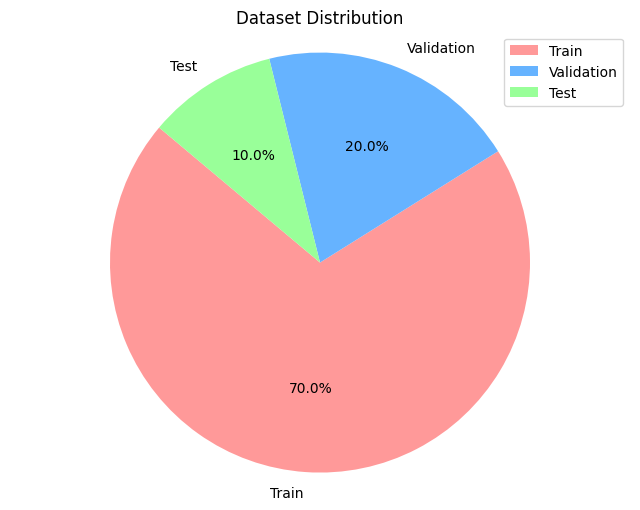

In [ ]:
import matplotlib.pyplot as plt
# train-val-test 비율을 pie chart로 나타냈습니다.
train_size = len(dataset_dict['train'])
val_size = len(dataset_dict['val'])
test_size = len(dataset_dict['test'])

sizes = [train_size, val_size, test_size]
labels = ['Train', 'Validation', 'Test']
colors = ['#ff9999','#66b3ff','#99ff99']


plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Dataset Distribution')
plt.legend(labels, loc="upper right")
plt.axis('equal')
plt.show()

In [ ]:
# sample을 확인하는 함수입니다.
def sample_check(type_, num):

    print("Sample_Idx: ", dataset[type_].select(range(10))['idx'][num], end="\n\n")

    print("Sample_label: ", dataset[type_].select(range(10))['label'][num], end="\n\n")

    print("Sample_premise ", dataset[type_].select(range(10))['premise'][num], end="\n\n")

    print("Sample_hypothesis: ", dataset[type_].select(range(10))['hypothesis'][num], end="\n\n")

    print("Sample_input_ids: ", "\n",len(dataset[type_].select(range(10))['input_ids'][num]),"\n",dataset[type_].select(range(10))['input_ids'][num], end="\n\n")

    print("Sample_decoded_input_ids: ", "\n",len(dataset[type_].select(range(10))['input_ids'][num]),"\n",tokenizer.decode(dataset[type_].select(range(10))['input_ids'][num]), end="\n\n")

    print("Sample_attention_mask: ", "\n", len(dataset[type_].select(range(10))['attention_mask'][num]),"\n", dataset[type_].select(range(10))['attention_mask'][num], end="\n\n")

sample_check(type_ = 'train', num = 3)

Sample_Idx:  259664

Sample_label:  2

Sample_premise  Las Vegas for Children

Sample_hypothesis:  Children aren't allowed in Vegas.

Sample_input_ids:  
 400 
 [101, 5869, 7136, 2005, 2336, 102, 2336, 4995, 1005, 1056, 3039, 1999, 7136, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

### 1.6 [My Code] EDA (1) - Length Check

- right skewed 되어 있기에 이를 동적 패딩에 오롯이 맡기는 것은 오히려 메모리 비효율을 초래합니다.

- 따라서 400 이상인 것만 잘라내고 400이하인 것은 패딩하지 않은 채 사용하는 것이 일반적입니다.

- 후에 데이터 collator를 통해 동적 패딩을 맡기더라도 400 이상은 자르는 게 맞다고 생각합니다.

- premise와 hypothesis의 평균 합은 200 정도이며, 표준편차의 합은 100정도입니다.

- 따라서 400으로 max_len으로 잡으면 평균 + 2표준편차이므로 99%의 데이터를 포함하게 됩니다.

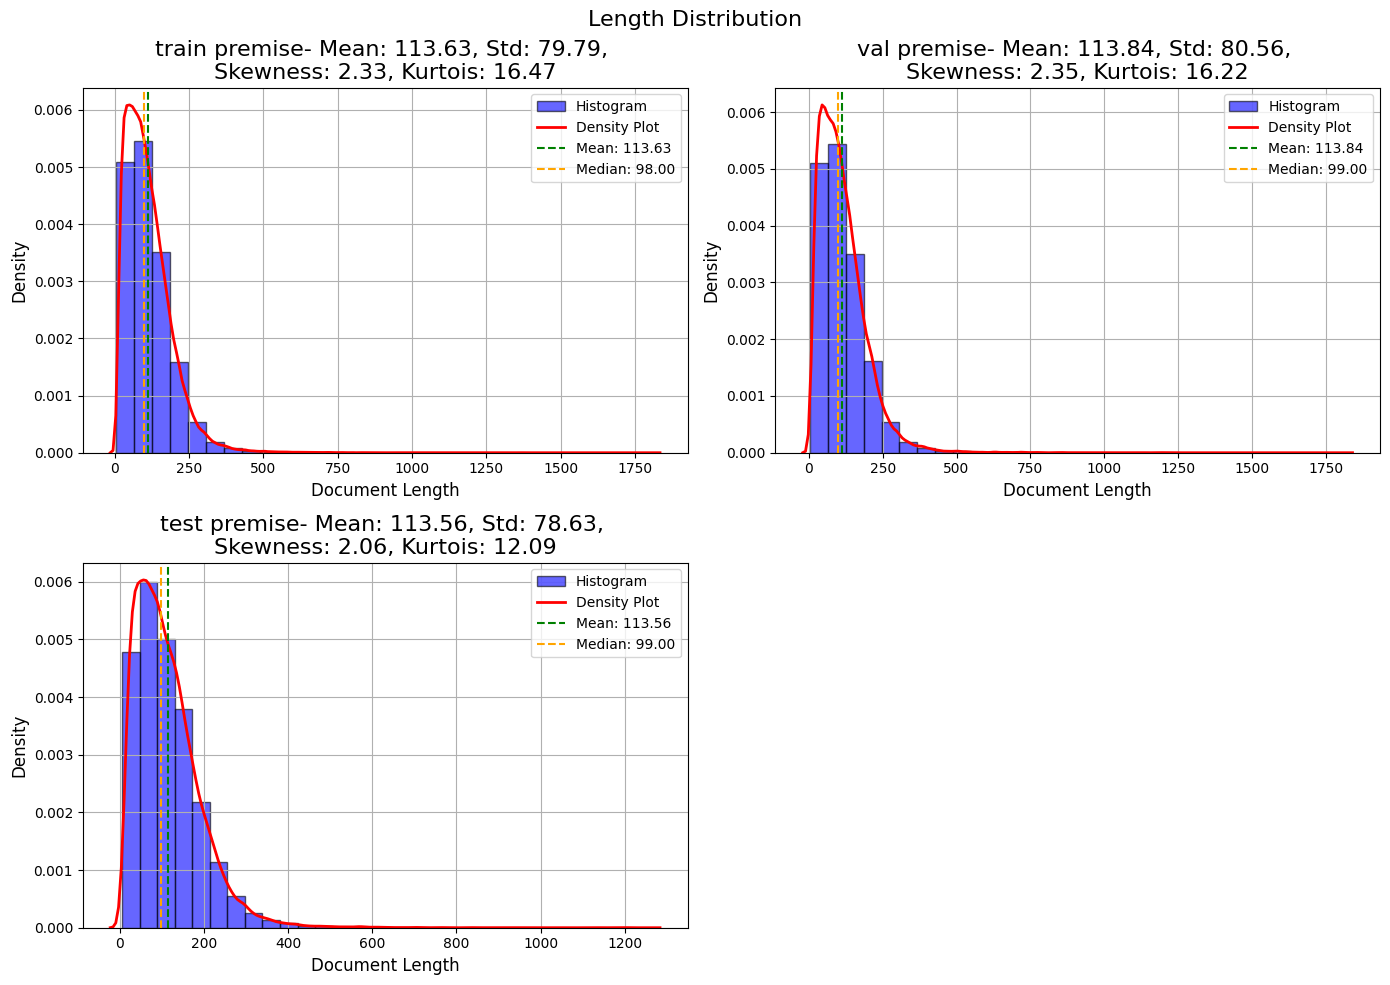

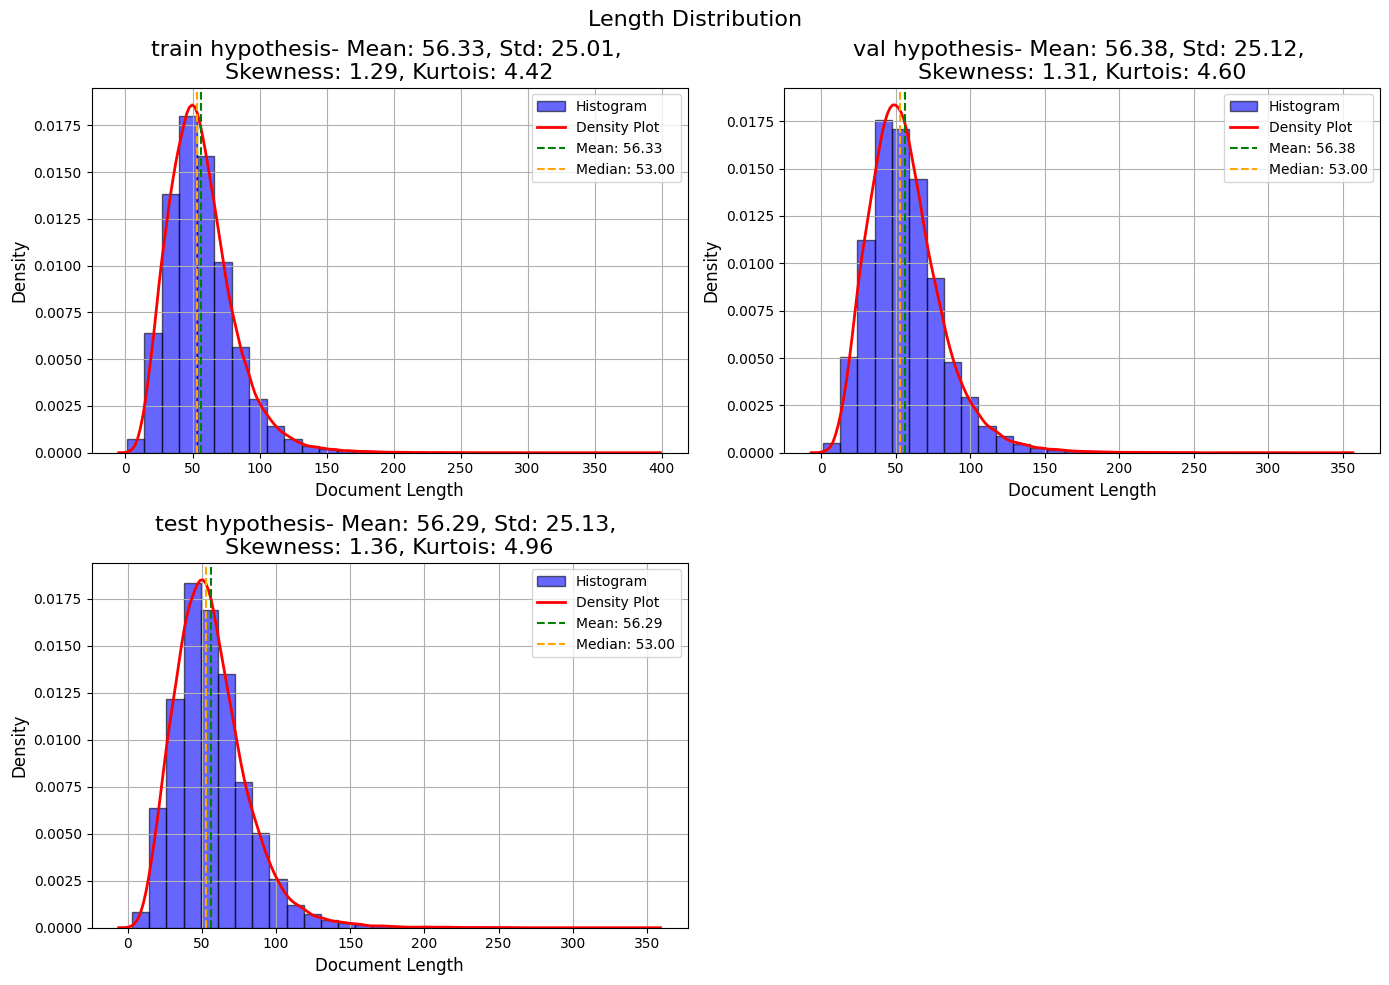

In [ ]:
# 텍스트 길이의 평균, 표준편차, 왜도, 첨도 계산
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import skew, kurtosis

def length_plot(data, name):
    plt.hist(data, bins=30, alpha=0.6, label=f'Histogram', color='blue', edgecolor='black', density=True)
    sns.kdeplot(data, label=f'Density Plot', color='red', linewidth=2)

    mean_value = np.mean(data)
    mean_value = np.mean(data)
    std_dev = np.std(data)
    skewness = skew(data)
    kurt = kurtosis(data)
    median_value = np.median(data)

    plt.axvline(mean_value, color='green', linestyle='--', linewidth=1.5, label=f'Mean: {mean_value:.2f}')
    plt.axvline(median_value, color='orange', linestyle='--', linewidth=1.5, label=f'Median: {median_value:.2f}')
    plt.title(f'{name}- Mean: {mean_value:.2f}, Std: {std_dev:.2f}, \nSkewness: {skewness:.2f}, Kurtois: {kurt:.2f}', fontsize=16)
    plt.xlabel('Document Length', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(True)

def final_plotting(type):
    plt.figure(figsize=(14,10))
    for i, name in enumerate(['train', 'val', 'test']):
        plt.subplot(2,2,i+1)
        length_plot([len(data)for data in dataset[name][type]], name+" "+type)
    plt.suptitle("Length Distribution", fontsize=16)
    plt.tight_layout()
    plt.show()

final_plotting('premise')

final_plotting('hypothesis')

### 1.7 [My Code] EDA (2) - Label Distribution

0: Entailment (포함) - 전제가 가설을 포함하는 경우

1: Neutral (중립) - 전제가 가설을 지지하지도, 반박하지도 않는 경우

2: Contradiction (모순) - 전제가 가설과 모순되는 경우

In [ ]:
# 라벨 분포도 계산
# 전체적으로 고르게 분포해 있기에 라벨 불균형을 그다지 문제시 하지 않았습니다.
import pandas as pd
import numpy as np
from IPython.display import display

df = pd.DataFrame(
    [
        pd.Series(dataset['train']['label']).value_counts(normalize=True).sort_index(),
        pd.Series(dataset['val']['label']).value_counts(normalize=True).sort_index(),
        pd.Series(dataset['test']['label']).value_counts(normalize=True).sort_index(),
    ],
    index = ['train','val','test'],
)

display(df)

,0,1,2
train,0.333105,0.332793,0.334102
val,0.335795,0.332917,0.331287
test,0.329964,0.337934,0.332103


## 2 [My Code] Training

### 2.1 [My Code] DataCollator

In [ ]:
from transformers import DataCollatorWithPadding
# 동적 패딩을 배치 단위로 하기 위해서 data collator를 사용합니다.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### 2.2 [My Code] Metric and Training args

In [ ]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# compute metrics은 반드시 아래와 같이 dict의 형태로 나와야 합니다.
# accuracy, f1, precision, recall을 모두 계산합니다.
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(predictions, labels)
    f1 = f1_score(predictions, labels, average="weighted")
    precision = precision_score(predictions, labels, average="weighted")
    recall = recall_score(predictions, labels, average="weighted")
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
        }

training_args = TrainingArguments(
    output_dir=results_dir,
    num_train_epochs=n_epochs,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_dir=results_dir,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    report_to="none"
)

### 2.3 [My Code] Trainer

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["val"],
    compute_metrics=compute_metrics,
    data_collator = data_collator
)

## 3 [My Code] Metric Check

### 3.1 [Log] Initial

In [ ]:
# 테스트 데이터셋에 대한 예측과 평가를 진행합니다.
initial_test_metrics = trainer.predict(test_dataset=dataset["test"])
initial_metrics = initial_test_metrics.metrics
print(f"Test Metrics:", "\n",
      "loss: ", initial_metrics['test_loss'], "\n",
      "accuracy: ", initial_metrics['test_accuracy'], "\n",
      "f1:", initial_metrics['test_f1'], "\n",
      "precision: ", initial_metrics['test_precision'], "\n",
      "recall:", initial_metrics['test_recall']
      )

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Metrics: 
 loss:  1.1007524728775024 
 accuracy:  0.33686435283033284 
 f1: 0.4278185851465551 
 precision:  0.6655328222360853 
 recall: 0.33686435283033284


### 3.2 [Log] Train

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,F1,Precision,Recall
1,1.039700,1.003510,0.001800,0.500452,0.501997,0.506057,0.500452
2,1.011600,0.990747,0.001800,0.511365,0.511014,0.512754,0.511365


Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,F1,Precision,Recall
1,1.039700,1.003510,0.001800,0.500452,0.501997,0.506057,0.500452
2,1.011600,0.990747,0.001800,0.511365,0.511014,0.512754,0.511365
3,1.003200,0.984126,0.001800,0.517324,0.521220,0.531971,0.517324
4,0.998500,0.977650,0.001800,0.521857,0.522314,0.523100,0.521857
5,0.994700,0.974721,0.001800,0.524200,0.525225,0.527728,0.524200
6,0.991000,0.972118,0.001800,0.526887,0.528965,0.534223,0.526887
7,0.988600,0.970130,0.001800,0.527485,0.527971,0.529221,0.527485
8,0.987100,0.969998,0.001800,0.527001,0.530376,0.540325,0.527001
9,0.984800,0.968530,0.001800,0.527536,0.530964,0.540176,0.527536
10,0.983800,0.966961,0.001800,0.530974,0.531780,0.533518,0.530974


TrainOutput(global_step=42960, training_loss=0.9982901518127327, metrics={'train_runtime': 9933.14, 'train_samples_per_second': 276.748, 'train_steps_per_second': 4.325, 'total_flos': 2.84497440359184e+17, 'train_loss': 0.9982901518127327, 'epoch': 10.0})

### 3.3 [My Code] Test Metric

In [ ]:
# 테스트 데이터셋에 대한 예측과 평가를 진행합니다.
test_metrics = trainer.predict(test_dataset=dataset["test"])
metrics = test_metrics.metrics
print(f"Test Metrics:", "\n",
      "loss: ", metrics['test_loss'], "\n",
      "accuracy: ", metrics['test_accuracy'], "\n",
      "f1:", metrics['test_f1'], "\n",
      "precision: ", metrics['test_precision'], "\n",
      "recall:", metrics['test_recall']
      )

Test Metrics: 
 loss:  0.9669053554534912 
 accuracy:  0.5275139415853938 
 f1: 0.5282343130140948 
 precision:  0.5298988056108217 
 recall: 0.5275139415853938


### 3.4 [My Code] Plotting

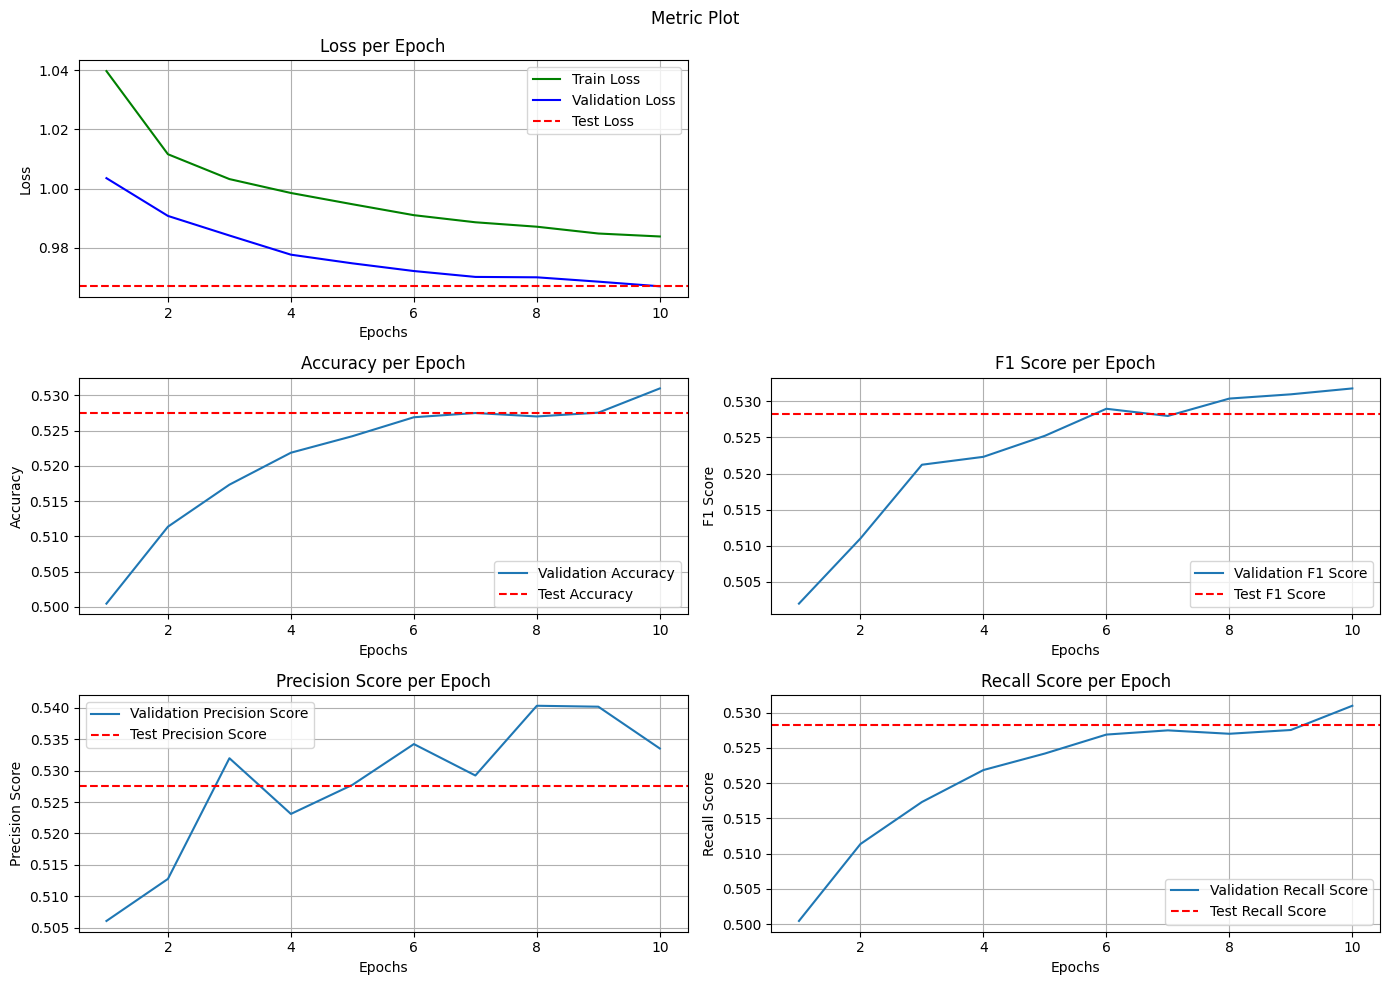

In [ ]:
import matplotlib.pyplot as plt

def plotting():
    # 로그 데이터 추출
    log_history = trainer.state.log_history

    # 메트릭 초기화
    epochs = []
    train_loss = []
    val_loss = []
    val_accuracy = []
    val_f1 = []
    val_precision = []
    val_recall = []

    # 로그 데이터 분리
    for log in log_history:
        if 'epoch' in log:
            current_epoch = log['epoch']
            if current_epoch not in epochs:
                epochs.append(current_epoch)
            if 'loss' in log:
                train_loss.append(log['loss'])
            if 'eval_loss' in log:
                val_loss.append(log['eval_loss'])
            if 'eval_accuracy' in log:
                val_accuracy.append(log['eval_accuracy'])
            if 'eval_f1' in log:
                val_f1.append(log['eval_f1'])
            if 'eval_precision' in log:
                val_precision.append(log['eval_precision'])
            if 'eval_recall' in log:
                val_recall.append(log['eval_recall'])

    test_loss = metrics['test_loss']
    test_accuracy = metrics['test_accuracy']
    test_f1 = metrics['test_f1']
    test_precision = metrics['test_accuracy']
    test_recall = metrics['test_f1']

    # 플로팅
    plt.figure(figsize=(14, 10))

    # 손실 플롯
    plt.subplot(3, 2, 1)
    plt.plot(epochs, train_loss, color = 'g', label='Train Loss')
    plt.plot(epochs, val_loss, color = 'b', label='Validation Loss')
    plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.grid(True)

    # 정확도 및 F1 스코어 플롯
    plt.subplot(3, 2, 3)
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 2, 4)
    plt.plot(epochs, val_f1, label='Validation F1 Score')
    plt.axhline(y=test_f1, color='r', linestyle='--', label='Test F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('F1 Score per Epoch')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 2, 5)
    plt.plot(epochs, val_precision, label='Validation Precision Score')
    plt.axhline(y=test_precision, color='r', linestyle='--', label='Test Precision Score')
    plt.xlabel('Epochs')
    plt.ylabel('Precision Score')
    plt.title('Precision Score per Epoch')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 2, 6)
    plt.plot(epochs, val_recall, label='Validation Recall Score')
    plt.axhline(y=test_recall, color='r', linestyle='--', label='Test Recall Score')
    plt.xlabel('Epochs')
    plt.ylabel('Recall Score')
    plt.title('Recall Score per Epoch')
    plt.legend()
    plt.grid(True)

    plt.suptitle(f"Metric Plot")
    plt.tight_layout()
    print("\n\n")

plotting()
plt.show()

In [ ]:
trainer.save_model("./saved_models")

## 4 [Log] Conclusion

- 학습 이전 random guessing을 했을 때 33%였던 정확도를 52%까지 끌어올렸음을 확인할 수 있음.

- 60만개 파라미터를 학습시키는데 10800초 정도의 시간이 소요되었음

In [ ]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 학습 가능한 파라미터 수 출력
trainable_params_lst = count_trainable_parameters(model)
train_runtime_lst = trainer.state.log_history[-1]['train_runtime']

result_df = pd.DataFrame([metrics])
initial_result_df = pd.DataFrame([initial_metrics])

result_df = pd.concat([result_df, initial_result_df], axis=0)
result_df.index = ['trained_model_metrics','initial_metrics']
result_df['trainable_parameters']  = trainable_params_lst
result_df['train_runtime'] = train_runtime_lst
result_df[['test_loss','test_accuracy','test_f1','trainable_parameters', 'train_runtime', 'test_runtime']]

,test_loss,test_accuracy,test_f1,trainable_parameters,train_runtime,test_runtime
trained_model_metrics,0.966905,0.527514,0.528234,592899,9933.14,106.9577
initial_metrics,1.100752,0.336864,0.427819,592899,9933.14,107.1253


## 5. [My Code] Classification By LLM

- 1) 분류 방식

    목표: 각 샘플에 대해 Entailment, Neutrality, Contradiction의 세 가지 관계를 원핫 인코딩 방식으로 분류합니다.

    세부 사항: 각 관계에 대해 True 또는 False를 예측하여 총 6개의 이진 분류를 수행합니다.

- 2) 모델 선택

    사용 모델: Qwen과 Small Thinker 두 가지 모델을 사용하며, 각각 약 3억 개의 매개변수를 가진 소형 언어 모델입니다.

- 3) 답변 형식 및 투표 로직

    답변 형식: 모델의 출력에서 마지막에 등장하는 "Answer" 키워드를 기준으로, 그 이후에 "True" 또는 **"true"**가 나타나면 해당 관계에 한 표를 부여합니다.

- 4) 동점 시 처리

    동점 상황: Entailment, Neutrality, Contradiction 중 두 개 이상의 관계가 동일한 득표수를 얻을 경우, OpenAI API를 통해 GPT-4.0 모델이 결정 투표를 수행합니다.

- 5) GPT-4.0의 역할

    분류 방식: GPT-4.0은 원핫 인코딩이 아닌 다중 클래스 분류를 통해 Entailment, Neutrality, Contradiction 중 하나를 선택합니다.
    이러한 전략을 통해 다양한 모델의 예측을 결합하여 성능을 향상시키고, 동점 상황에서는 고성능 모델을 활용하여 최종 결정을 내리는 방식을 구현합니다.

- 6) 전략

        1) Chain of Thought (CoT) 프롬프트 엔지니어링

        정의: 모델이 문제를 단계별로 사고하도록 유도하여 복잡한 문제 해결 능력을 향상시키는 기법입니다.

        특징: 모델이 중간 추론 단계를 명시적으로 표현함으로써 논리적 사고 과정을 강화합니다.

        2) Few-Shot Learning 프롬프트 엔지니어링

        정의: 모델에게 몇 가지 예시를 제공하여 새로운 작업에 대한 적응력을 높이는 기법입니다.

        특징: 제한된 예시를 통해 모델이 특정 작업의 패턴을 학습하고 일반화할 수 있도록 돕습니다.

        3) Hard Voting 앙상블 기법

        정의: 여러 모델의 예측 결과 중 다수결 원칙에 따라 최종 예측을 결정하는 앙상블 방법입니다.

        특징: 각 모델의 독립적인 판단을 결합하여 전체적인 예측 성능을 향상시킵니다.


### 5.1 [My Code] Prompt Template

In [ ]:
# sllm이 일차 투표를 하기 위한 프롬프트 탬플릿입니다.
prompt_template = """
# Context #

You are assisting with a binary classification task, which is about {task_name}. The definition of {task_name} is that {task}.

# Objective #

Perform binary classification to determine whether {task_name} is true or false. If {task_name} is true, respond with 'True'; otherwise, respond with 'False'.

# Style #

Concise and direct.

# Tone #

Neutral and objective.

# Audience #

A technical user focused on binary classification.

# Response_format #

Provide your response in the following format:
Answer: "True" or "False"

Include a step-by-step reasoning process explaining the classification in a logical manner before providing the final answer.

# Example #

Example 1:
Premise: A cat is sleeping on the couch.
Hypothesis: An animal is sleeping on the couch.
Reasoning(Step-by-step):
1. Identify the main subject in the premise: A cat.
2. Determine if the hypothesis matches the premise: A cat is an animal, and the hypothesis states an animal is sleeping.
3. The hypothesis accurately reflects the premise.
Answer: True

Example 2:
Premise: The child is playing outside.
Hypothesis: The child is sitting inside.
Reasoning(Step-by-step):
1. Identify the main subject and action in the premise: The child is playing outside.
2. Determine if the hypothesis contradicts the premise: The premise indicates outdoor activity, while the hypothesis states indoor activity.
3. The hypothesis contradicts the premise.
Answer: False

##########

Please classify the following:

Premise: {premise}
Hypothesis: {hypothesis}
Reasoning(Step-by-step):
1.
2.
3.
Answer:


"""

### 5.2 [My Code] Terminology Definition

In [ ]:
# entailment, neutral, contradiction의 정의입니다.
# few-shot classification을 위하여 예시를 작성하였습니다.
# Chain of Thought을 적용하였습니다.
definition = {
  "entailment": {
    "task_name": "entailment",
    "task": "Entailment occurs when the information in the hypothesis is a logical consequence of the premise. In simpler terms, if the premise is true, the hypothesis must also be true.",
    "examples": {
      "positive": """
        Premise: A cat is sleeping on the couch.
        Hypothesis: An animal is sleeping on the couch.
        Reasoning(Step-by-step):
        1. Identify the main subject in the premise: A cat.
        2. Determine if the hypothesis generalizes correctly: A cat is an animal, and the hypothesis states an animal is sleeping on the couch.
        3. The hypothesis is a logical consequence of the premise.
        Answer: True
      """,
      "negative": """
        Premise: The child is playing outside.
        Hypothesis: The child is sitting inside.
        Reasoning(Step-by-step):
        1. Identify the main subject and action in the premise: The child is playing outside.
        2. Determine if the hypothesis matches or contradicts the premise: The hypothesis states the child is sitting inside, which contradicts the premise.
        3. The hypothesis is not entailed by the premise.
        Answer: False
      """
    }
  },
  "neutral": {
    "task_name": "neutrality",
    "task": "A neutral relationship exists when the premise provides some information, but the truth or falsity of the hypothesis cannot be conclusively determined from it. In other words, the hypothesis might be true or false, but the premise does not provide enough evidence to confirm or deny it.",
    "examples": {
      "positive": """
        Premise: A man is walking in the park.
        Hypothesis: The man is wearing a hat.
        Reasoning(Step-by-step):
        1. Identify the information provided in the premise: A man is walking in the park.
        2. Analyze if the premise provides evidence for the hypothesis: The premise does not mention anything about a hat.
        3. The hypothesis cannot be confirmed or denied based on the premise.
        Answer: True
      """,
      "negative": """
        Premise: A cat is sleeping on the couch.
        Hypothesis: An animal is sleeping on the couch.
        Reasoning(Step-by-step):
        1. Identify the main subject in the premise: A cat.
        2. Check if the hypothesis generalizes correctly: A cat is an animal, and the hypothesis correctly states an animal is sleeping on the couch.
        3. The hypothesis is entailed by the premise, so it is not neutral.
        Answer: False
      """
    }
  },
  "contradiction": {
    "task_name": "contradiction",
    "task": "A contradiction exists when the hypothesis cannot possibly be true if the premise is true. The information in the hypothesis is logically inconsistent with the information in the premise.",
    "examples": {
      "positive": """
        Premise: The child is playing outside.
        Hypothesis: The child is sitting inside.
        Reasoning(Step-by-step):
        1. Identify the action and location in the premise: The child is playing outside.
        2. Compare with the hypothesis: The hypothesis states the child is sitting inside, which is logically inconsistent with the premise.
        3. The hypothesis contradicts the premise.
        Answer: True
      """,
      "negative": """
        Premise: A man is playing a guitar on the stage.
        Hypothesis: Someone is performing music.
        Reasoning(Step-by-step):
        1. Identify the main action in the premise: A man is playing a guitar on the stage.
        2. Analyze if the hypothesis matches the premise: Playing a guitar is performing music, so the hypothesis is consistent with the premise.
        3. The hypothesis does not contradict the premise.
        Answer: False
      """
    }
  }
}


### 5.3 [My Code]Prompt For GPT

In [ ]:
# gpt는 2차 결선 투표를 진행해야 할 때 casting votor 역할을 수행합니다.
# 아래는 gpt api를 통해 호출할 prompt입니다.
gpt_prompt = {
    "entailment-contradiction":
        """
        # Context #

            We are performing a natural language inference (NLI) task where the goal is to classify the relationship between a premise and a hypothesis into one of three categories: "entailment", "neutral", or "contradiction".

            - Premise: "{premise}"
            - Hypothesis: "{hypothesis}"

            The task involves analyzing the logical relationship between the premise and the hypothesis to determine the correct classification.

        # Objective #

            Identify whether the relationship between the premise and hypothesis is "entailment" or "contradiction" when the votes from the models are tied for these two categories, with "neutral" having fewer votes.

        # Style #

            Concise, step-by-step, and logically structured.

        # Tone #

            Neutral and objective.

        # Audience #

            Technical users and researchers in natural language processing (NLP) and machine learning.

        # Response Format #

            Provide your response in the following format:
            - Reasoning (Step-by-step): Explain the logical analysis in three distinct steps to evaluate "entailment" and "contradiction."
            - Answer: Respond with either "entailment" or "contradiction."

        # Example #

            Example 1:
            Premise: A cat is sleeping on the couch.
            Hypothesis: An animal is sleeping on the couch.

            Reasoning (Step-by-step):
            1. Identify the subject and action in the premise: A cat is sleeping on the couch.
            2. Determine if the hypothesis is logically entailed by the premise: A cat is an animal, and the hypothesis aligns with the information in the premise.
            3. Conclude that the hypothesis logically follows from the premise.

            Answer: entailment

            Example 2:
            Premise: The child is playing outside.
            Hypothesis: The child is sitting inside.

            Reasoning (Step-by-step):
            1. Identify the subject and action in the premise: The child is playing outside.
            2. Determine if the hypothesis contradicts the premise: The premise indicates outdoor activity, while the hypothesis suggests the opposite—indoor inactivity.
            3. Conclude that the hypothesis directly conflicts with the premise.

            Answer: contradiction

        ##########

        Please classify the following:

        Premise: {premise}
        Hypothesis: {hypothesis}

        Reasoning (Step-by-step):
        1.
        2.
        3.

        Answer:
        """,
    "entailment-neutral":"""
        # Context #

            We are performing a natural language inference (NLI) task where the goal is to classify the relationship between a premise and a hypothesis into one of three categories: "entailment", "neutral", or "contradiction".

            - Premise: "{premise}"
            - Hypothesis: "{hypothesis}"

            The task involves analyzing the logical relationship between the premise and the hypothesis to decide the correct classification.

        # Objective #

            Identify whether the relationship between the premise and hypothesis is "entailment" or "neutral" when the votes from the models are tied for these two categories, with "contradiction" having fewer votes.

        # Style #

            Concise, step-by-step, and logically structured.

        # Tone #

            Neutral and objective.

        # Audience #

            Technical users and researchers in natural language processing (NLP) and machine learning.

        # Response Format #

            Provide your response in the following format:
            - Reasoning (Step-by-step): Explain the logical analysis in three distinct steps to evaluate "entailment" and "neutral."
            - Answer: Respond with either "entailment" or "neutral."

        # Example #

            Example 1:
            Premise: A man is walking in the park.
            Hypothesis: The man is wearing a hat.

            Reasoning (Step-by-step):
            1. Identify the subject and action in the premise: A man is walking in the park.
            2. Determine if the hypothesis logically follows from the premise: The premise does not mention anything about a hat, so the hypothesis introduces new information.
            3. Conclude that the relationship is neutral because the premise does not provide enough evidence to confirm or deny the hypothesis.

            Answer: neutral

            Example 2:
            Premise: A cat is sitting on the couch.
            Hypothesis: An animal is sitting on the couch.

            Reasoning (Step-by-step):
            1. Identify the subject and action in the premise: A cat is sitting on the couch.
            2. Determine if the hypothesis logically follows from the premise: A cat is an animal, so the hypothesis aligns with the information in the premise.
            3. Conclude that the hypothesis logically follows from the premise.

            Answer: entailment

        ##########

        Please classify the following:

        Premise: {premise}
        Hypothesis: {hypothesis}

        Reasoning (Step-by-step):
        1.
        2.
        3.

        Answer:
    """,
    "neutral-contradiction":"""
        # Context #

            We are performing a natural language inference (NLI) task where the goal is to classify the relationship between a premise and a hypothesis into one of three categories: "entailment", "neutral", or "contradiction".

            - Premise: "{premise}"
            - Hypothesis: "{hypothesis}"

            The task involves analyzing the logical relationship between the premise and the hypothesis to determine the most appropriate classification.

        # Objective #

            Identify whether the relationship between the premise and hypothesis is "neutral" or "contradiction" when the votes from the models are tied for these two categories, with "entailment" having fewer votes.

        # Style #

            Concise, step-by-step, and logically structured.

        # Tone #

            Neutral and objective.

        # Audience #

            Technical users and researchers in natural language processing (NLP) and machine learning.

        # Response Format #

            Provide your response in the following format:
            - Reasoning (Step-by-step): Explain the logical analysis in three distinct steps to evaluate "neutral" and "contradiction."
            - Answer: Respond with either "neutral" or "contradiction."

        # Example #

            Example 1:
            Premise: A man is walking in the park.
            Hypothesis: The man is carrying a bag.

            Reasoning (Step-by-step):
            1. Identify the subject and action in the premise: A man is walking in the park.
            2. Determine if the hypothesis introduces unrelated information: The premise does not provide any evidence about a bag, so the hypothesis introduces new information.
            3. Conclude that the relationship is neutral because the premise does not confirm or deny the hypothesis.

            Answer: neutral

            Example 2:
            Premise: The child is playing outside.
            Hypothesis: The child is sitting inside.

            Reasoning (Step-by-step):
            1. Identify the subject and action in the premise: The child is playing outside.
            2. Determine if the hypothesis contradicts the premise: The hypothesis directly conflicts with the premise, as the premise states the child is outside, while the hypothesis states the child is inside.
            3. Conclude that the relationship is contradiction because the hypothesis cannot be true if the premise is true.

            Answer: contradiction

        ##########

        Please classify the following:

        Premise: {premise}
        Hypothesis: {hypothesis}

        Reasoning (Step-by-step):
        1.
        2.
        3.

        Answer:
    """,
    "entailment-neutral-contradiction":"""
        # Context #

            We are performing a natural language inference (NLI) task where the goal is to classify the relationship between a premise and a hypothesis into one of three categories: "entailment", "neutral", or "contradiction".

            - Premise: "{premise}"
            - Hypothesis: "{hypothesis}"

            The task involves analyzing the logical relationship between the premise and the hypothesis to determine the most appropriate classification.

        # Objective #

            Identify whether the relationship between the premise and hypothesis is "entailment", "neutral", or "contradiction" when the votes from the models are tied across all three categories.

        # Style #

            Concise, step-by-step, and logically structured.

        # Tone #

            Neutral and objective.

        # Audience #

            Technical users and researchers in natural language processing (NLP) and machine learning.

        # Response Format #

            Provide your response in the following format:
            - Reasoning (Step-by-step): Explain the logical analysis in four distinct steps to evaluate "entailment", "neutral", and "contradiction."
            - Answer: Respond with "entailment", "neutral", or "contradiction."

        # Examples #

            ### Example 1
            Premise: A bird is flying in the sky.
            Hypothesis: An animal is moving through the air.

            Reasoning (Step-by-step):
            1. Identify the subject and action in the premise: A bird is flying in the sky.
            2. Determine if the hypothesis logically follows from the premise: A bird is an animal, and the hypothesis states that an animal is moving through the air. This aligns with the information in the premise.
            3. Evaluate if the hypothesis introduces plausible new information: The hypothesis does not introduce additional unrelated details.
            4. Conclude that the hypothesis is logically entailed by the premise.

            Answer: entailment

            ### Example 2
            Premise: A woman is reading a book on the porch.
            Hypothesis: The woman is drinking tea.

            Reasoning (Step-by-step):
            1. Identify the subject and action in the premise: A woman is reading a book on the porch.
            2. Determine if the hypothesis logically follows from the premise: The premise does not mention anything about tea or drinking.
            3. Evaluate if the hypothesis introduces plausible new information: Drinking tea is possible but not explicitly supported by the premise.
            4. Conclude that the relationship is neutral because the premise does not provide enough evidence to confirm or deny the hypothesis.

            Answer: neutral

            ### Example 3
            Premise: The car is parked in the garage.
            Hypothesis: The car is driving down the street.

            Reasoning (Step-by-step):
            1. Identify the subject and action in the premise: The car is parked in the garage.
            2. Determine if the hypothesis logically follows from the premise: The hypothesis states the car is driving, which conflicts with the information in the premise.
            3. Evaluate if the hypothesis introduces plausible new information: The hypothesis directly contradicts the premise.
            4. Conclude that the hypothesis contradicts the premise.

            Answer: contradiction

        ##########

        Please classify the following:

        Premise: {premise}
        Hypothesis: {hypothesis}

        Reasoning (Step-by-step):
        1.
        2.
        3.
        4.

        Answer:
    """
}


## 6. [My Code] Model Preparation

### 6.1 [My Code] Model Config

In [ ]:
text_model_dict = {
    "qwen": {
        "name" : "Qwen/Qwen2.5-7B-Instruct",
        "device" : 'auto',
        "generation_params": {
            "max_new_tokens" : 256,
            "temperature": 0.3,
            "top_p": 0.9,
            "top_k": 10,
            "no_repeat_ngram_size": 2,
            "repetition_penalty": 1.5,
            "early_stopping":True,
            "return_full_text": False,
            "num_beams" : 2,
            "do_sample" : True
        }
    },
    "mistral": {
        "name" : "mistralai/Mistral-7B-Instruct-v0.3",
        "device" : 'auto',
        "generation_params": {
            "max_new_tokens" : 256,
            "temperature": 0.3,
            "top_p": 0.9,
            "top_k": 10,
            "no_repeat_ngram_size": 2,
            "repetition_penalty": 1.5,
            "early_stopping":True,
            "return_full_text": False,
            "num_beams" : 2,
            "do_sample" : True
        }
    },
    "smallthinker": {
        "name" : "PowerInfer/SmallThinker-3B-Preview",
        "device" : 'auto',
        "generation_params": {
            "max_new_tokens" :256,
            "temperature": 0.3,
            "top_p": 0.9,
            "top_k": 10,
            "no_repeat_ngram_size": 2,
            "repetition_penalty": 1.5,
            "early_stopping":True,
            "return_full_text": False,
            "num_beams" : 2,
            "do_sample" : True
        }
    }
}

### 6.2 [My Code] Qwen

In [ ]:
from torch import nn
import torch
from transformers import pipeline

class Qwen(nn.Module):
    def __init__(self, config):
        super(Qwen, self).__init__()
        self.config = config
        self.pipe = pipe = pipeline(
            "text-generation",
            model=self.config['name'],
            torch_dtype=torch.bfloat16,
            device_map=self.config['device']
        )

        self.generation_params = self.config['generation_params']

    def forward(self, prompt):
        messages = [
            {"role": "user", "content": prompt},
        ]
        return self.pipe(prompt, **self.generation_params)

### 6.3 [My Code] Mistral

In [ ]:
class Mistral(nn.Module):
    def __init__(self, config):
        super(Mistral, self).__init__()
        self.config = config
        self.pipe = pipeline(
            "text-generation",
            model=self.config['name'],
            torch_dtype=torch.bfloat16,
            device_map=self.config['device'],
            trust_remote_code=True
        )
        self.generation_params = self.config['generation_params']

    def forward(self, prompt):
        messages = [
            # {"role": "system", "content": "You are a pirate chatbot who always responds in pirate speak!"},
            {"role": "user", "content": prompt},
        ]
        return self.pipe(prompt, **self.generation_params)

### 6.4 [My Code] SmallThinker

In [ ]:
class SmallThinker(nn.Module):
    def __init__(self, config):
        super(SmallThinker, self).__init__()
        self.config = config
        self.pipe = pipeline(
            "text-generation",
            model=self.config['name'],
            torch_dtype=torch.bfloat16,
            device_map=self.config['device']
        )
        self.generation_params = self.config['generation_params']

    def forward(self, prompt):
        messages = [
            {"role": "user", "content": "Who are you?"},
        ]
        return self.pipe(prompt, **self.generation_params)

### 6.5 [My Code] Wrapping Class

In [ ]:
import copy
import time

class LlmClassifier(nn.Module):
    def __init__(self, config):
        super(LlmClassifier, self).__init__()
        self.config = config
        self.qwen = Qwen(self.config['qwen'])
        # self.mistral = Mistral(self.config['mistral'])
        self.smallthinker = SmallThinker(self.config['smallthinker'])

        self.result_dict = {
            "entailment":0,
            "neutral":0,
            "contradiction":0
            }

    def _get_prompt(premise, hypothesis, prompt_template, definition, label):
        task_name = definition[label]['task_name']
        task = definition[label]['task']
        example_positive = definition[label]['examples']['positive']
        example_negative = definition[label]['examples']['negative']
        prompt = prompt_template.format(
            task = task,
            task_name = task_name,
            example_positive = example_positive,
            example_negative = example_negative,
            premise = premise,
            hypothesis = hypothesis
        )
        return prompt

    @staticmethod
    def _label_calculator(output, label, result_dict):
        output = f"{output}"
        output = output.split("Answer")[-1]
        if label == 'entailment' and ('True' in output or 'true' in output):
            result_dict['entailment'] += 1
        elif label == 'neutral' and ('True' in output or 'true' in output):
            result_dict['neutral'] += 1
        elif label == 'contradiction' and ('True' in output or 'true' in output):
            result_dict['contradiction'] += 1

        return result_dict

    def forward(self, premise, hypothesis, iter = 1):
        output_dict = {"entailment":[], 'neutral':[], 'contradiction':[]}
        label = "entailment"
        print(f"1/3 {label}...")
        prompt = LlmClassifier._get_prompt(premise, hypothesis, prompt_template, definition, label)
        for _ in range(iter):
            print("Qwen")
            start_time = time.time()
            output_1 = self.qwen(prompt)
            end_time = time.time()
            print(f"Qwen 실행 시간: {end_time - start_time:.3f}초")

            # output_2 = self.mistral(prompt)

            print("SmallThinker")
            start_time = time.time()
            output_3 = self.smallthinker(prompt)
            end_time = time.time()
            print(f"SmallThinker 실행 시간: {end_time - start_time:.3f}초")

            self.result_dict = LlmClassifier._label_calculator(output_1,label,self.result_dict)
            # self.result_dict = LlmClassifier._label_calculator(output_2,label,self.result_dict)
            self.result_dict = LlmClassifier._label_calculator(output_3,label,self.result_dict)

            output_dict[label].append(output_1)
            # output_dict[label].append(output_2)
            output_dict[label].append(output_3)


        label = "neutral"
        prompt = LlmClassifier._get_prompt(premise, hypothesis, prompt_template, definition, label)
        print(f"2/3 {label}...")
        for _ in range(iter):
            print("Qwen")
            start_time = time.time()
            output_1 = self.qwen(prompt)
            end_time = time.time()
            print(f"Qwen 실행 시간: {end_time - start_time:.3f}초")

            # output_2 = self.mistral(prompt)

            print("SmallThinker")
            start_time = time.time()
            output_3 = self.smallthinker(prompt)
            end_time = time.time()
            print(f"SmallThinker 실행 시간: {end_time - start_time:.3f}초")

            self.result_dict = LlmClassifier._label_calculator(output_1,label,self.result_dict)
            # self.result_dict = LlmClassifier._label_calculator(output_2,label,self.result_dict)
            self.result_dict = LlmClassifier._label_calculator(output_3,label,self.result_dict)

            output_dict[label].append(output_1)
            # output_dict[label].append(output_2)
            output_dict[label].append(output_3)

        label = "contradiction"
        prompt = LlmClassifier._get_prompt(premise, hypothesis, prompt_template, definition, label)
        print(f"3/3 {label}...")
        for _ in range(iter):
            print("Qwen")
            start_time = time.time()
            output_1 = self.qwen(prompt)
            end_time = time.time()
            print(f"Qwen 실행 시간: {end_time - start_time:.3f}초")

            # output_2 = self.mistral(prompt)

            print("SmallThinker")
            start_time = time.time()
            output_3 = self.smallthinker(prompt)
            end_time = time.time()
            print(f"SmallThinker 실행 시간: {end_time - start_time:.3f}초")

            self.result_dict = LlmClassifier._label_calculator(output_1,label,self.result_dict)
            # self.result_dict = LlmClassifier._label_calculator(output_2,label,self.result_dict)
            self.result_dict = LlmClassifier._label_calculator(output_3,label,self.result_dict)

            output_dict[label].append(output_1)
            # output_dict[label].append(output_2)
            output_dict[label].append(output_3)

        result = copy.deepcopy(self.result_dict)
        self.result_dict = {
            "entailment":0,
            "neutral":0,
            "contradiction":0
            }
        return {'result_dict': result, 'premise': premise, 'hypothesis': hypothesis, 'output_dict':output_dict}

llm_classifier = LlmClassifier(text_model_dict)

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/27.8k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Device set to use cuda:0


config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.6k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.84G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/5.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

Device set to use cuda:0


### 6.6 [My Code] Gpt API Class

In [ ]:
from openai import OpenAI

class OpenaiClassifier():
    def __init__(self, result_dict, gpt_prompt):
        self.client = OpenAI()
        self.votes = result_dict['result_dict']
        self.premise = result_dict['premise']
        self.hypothesis = result_dict['hypothesis']
        self.prompt = gpt_prompt

    @staticmethod
    def _label_calculator(output, result_dict):
        output = output.split("Answer")[-1]
        if ('entailment' in output):
            result_dict['entailment'] += 1
        elif  ('neutral' in output):
            result_dict['neutral'] += 1
        elif  ('contradiction' in output):
            result_dict['contradiction'] += 1

        return result_dict

    @staticmethod
    def _prompt_select(top_labels, prompt):
        if len(top_labels) == 2 and 'entail' not in f"{top_labels}":
            return prompt['neutral-contradiction']
        elif len(top_labels) == 2 and 'contradiction' in f"{top_labels}":
            return prompt['entailment-contradiction']
        elif len(top_labels) == 2 and 'neutral' in f"{top_labels}":
            return prompt['entailment-neutral']
        elif len(top_labels) == 3:
            return prompt['entailment-neutral-contradiction']

    @staticmethod
    def _check_casting_vote(result_dict):
        max_votes = max(result_dict.values())
        top_labels = [key for key, value in result_dict.items() if value == max_votes]
        return top_labels

    def _resolve_with_openai(self, premise, hypothesis, votes, prompt):
        prompt = prompt.format(
            premise = premise,
            hypothesis = hypothesis,
            entailment_votes = votes['entailment'],
            contradiction_votes = votes['contradiction'],
            neutral_votes = votes['neutral']
        )
        completion = self.client.chat.completions.create(
            model="gpt-4o",
            store=True,
            messages=[
                {"role": "user", "content": prompt}
            ],
            max_tokens = 512
        )
        return completion.choices[0].message.content

    def forward(self, premise, hypothesis):
        top_labels = OpenaiClassifier._check_casting_vote(self.votes)
        if len(top_labels) == 1:
            return self.votes, None
        else:
            prompt = OpenaiClassifier._prompt_select(top_labels, self.prompt)
            openai_output = self._resolve_with_openai(premise, hypothesis, self.votes, prompt)
            self.votes = OpenaiClassifier._label_calculator(openai_output, self.votes)
            return self.votes, openai_output

## 7 [My Code] Inference

In [ ]:
# 테스트 데이터셋은 100개만 사용합니다.
nums = 200
# nums = 20
test_dataset = dataset['test'].select(range(nums))

In [ ]:
from tqdm import tqdm
import random
from collections import defaultdict
# 언어모델 기반 분류기 추론 시작
def decide_label(result_dict):

    value_to_keys = defaultdict(list)
    for key, value in result_dict.items():
        value_to_keys[value].append(key)

    max_value = max(value_to_keys.keys())

    keys_with_max_value = value_to_keys[max_value]

    if len(keys_with_max_value) == 1:
        result_key = keys_with_max_value[0]
    else:
        result_key = random.choice(keys_with_max_value)

    return result_key

def inference(premise, hypothesis):
    result_dict = llm_classifier(premise, hypothesis)
    openai_classifier = OpenaiClassifier(result_dict, gpt_prompt)
    final_result_dict, openai_output = openai_classifier.forward(premise, hypothesis)
    return final_result_dict, result_dict['output_dict'], openai_output

label_lst = []
pred_soft_lst = []
pred_lst = []
output_dict = {}
counter = 0
for data in tqdm(test_dataset, desc="Language Model Classification"):
    print(f"### Start {counter+1} Sample")
    premise = data['premise']
    hypothesis = data['hypothesis']
    label = data['label']
    label_lst.append(label)

    result_dict, llm_output, gpt_output = inference(premise, hypothesis)
    pred_soft_lst.append(result_dict)
    output_dict[counter] = {'llm_output':llm_output, 'gpt_output':gpt_output}

    counter += 1

    pred_key = decide_label(result_dict)
    pred = label2idx[pred_key]
    pred_lst.append(pred)
    print("### End")

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
# 언어모델 기반 metric
def cal_metrics(predictions, labels):

    accuracy = accuracy_score(predictions, labels)
    f1 = f1_score(predictions, labels, average="weighted")
    precision = precision_score(predictions, labels, average="weighted")
    recall = recall_score(predictions, labels, average="weighted")
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
        }

llm_metrics = cal_metrics(pred_lst, label_lst)
print(f"LLM Metrics:", "\n",
      "accuracy: ", llm_metrics['accuracy'], "\n",
      "f1:", llm_metrics['f1'], "\n",
      "precision: ", llm_metrics['precision'], "\n",
      "recall:", llm_metrics['recall']
      )

LLM Metrics: 
 accuracy:  0.595 
 f1: 0.5943312392339649 
 precision:  0.5961089789149491 
 recall: 0.595


In [ ]:
# bert 기반 metric
test_metrics_ = trainer.predict(test_dataset=test_dataset)
metrics = test_metrics_.metrics
print(f"Test Metrics:", "\n",
      "loss: ", metrics['test_loss'], "\n",
      "accuracy: ", metrics['test_accuracy'], "\n",
      "f1:", metrics['test_f1'], "\n",
      "precision: ", metrics['test_precision'], "\n",
      "recall:", metrics['test_recall']
      )

Test Metrics: 
 loss:  0.9652957320213318 
 accuracy:  0.53 
 f1: 0.5297576992753623 
 precision:  0.5296825396825396 
 recall: 0.53


## 8 [My Code] Conclusion

LLM 기반 분류기 vs. DistilBERT 기반 분류기 비교
- 1) 추론 속도:

    - LLM 기반 분류기는 200개 샘플에 대해 10,800초가 소요됨.

    - DistilBERT 기반 분류기는 40,000개 샘플을 110초 만에 처리 가능.

    - 동일 샘플 개수 기준으로 계산 시 LLM 기반 분류기는 DistilBERT 대비 약 20,000배 느림.

    - 추론 시간은 LLM 기반 분류기의 치명적인 단점으로 지적됨.

- 2) 학습 필요 여부:

    - LLM 기반 분류기는 학습이 필요 없음.
    
    - 장점 1: 학습에 소요되는 시간을 절약 가능.
    
    - 장점 2: 라벨이 없어도 적절한 성능을 가진 모델 구현 가능.
    
    - LLM 기반 분류기는 프롬프트 엔지니어링과 모델 배치만으로 준수한 성능을 발휘함.

- 3) 성능 비교:

    - DistilBERT 기반 분류기의 정확도와 F1: 53%.
    
    - LLM 기반 분류기의 정확도와 F1: 59%.
    
    - LLM 기반 분류기는 성능에서 약 10%의 개선을 보임.

- 4) 시사점:

    - 시간과 성능, 그리고 라벨 데이터의 존재 여부에 따라 어떤 방식으로 추론할 것인지 하나의 선택을 더 할 수 있게 되었음.

    - 단, 치명적으로 느린 해당 방식을 어떻게 최적화 할 수 있을지는 고민해봐야 함

    - 데이터 라벨링을 해야 하는 상황이라면, 유용하게 사용할 수 있는 방법이라고 생각됨

In [ ]:
# 언어모델 기반 metric과 bert 기반 metric 비교
result_df = pd.DataFrame([llm_metrics])
initial_result_df = pd.DataFrame([metrics])
initial_result_df = initial_result_df.rename(columns={'test_accuracy':'accuracy','test_f1':'f1','test_precision':'precision', 'test_recall':'recall'})
initial_result_df = initial_result_df[['accuracy', 'f1', 'precision','recall']]

result_df_ = pd.concat([result_df, initial_result_df], axis=0)
result_df_.index = ['llm_metrics','distil bert_metrics']
display(result_df_)

,accuracy,f1,precision,recall
llm_metrics,0.595,0.594331,0.596109,0.595
distil bert_metrics,0.530,0.529758,0.529683,0.530
